<a href="https://colab.research.google.com/github/pakrentos/eeg_connectivity/blob/master/psr_mpl_eeg_nikita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!rm -rf /content/src
!git init
!git remote add origin https://github.com/pakrentos/eeg_connectivity/
!git fetch origin
!git checkout origin/master -- src

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 89 (delta 40), reused 36 (delta 14), pack-reused 0
Unpacking objects: 100% (89/89), done.
From https://github.com/pakrentos/eeg_connectivity
 * [new branch]      evgen      -> origin/evgen
 * [new branch]      master     -> origin/master


In [64]:
from src import *
from src.psr import lagged_ami
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from src.psr import global_false_nearest_neighbors, lagged_ami
import warnings
warnings.filterwarnings('ignore')
from statistics import stdev, mean
import json

In [78]:
sub_dir = '/content/drive/My Drive/Subjects'
subject_scores = []

In [5]:
def separate(arr, bins):
    return np.array(np.split(arr, bins))

def prepare(arr):
    arr = np.random.permutation(arr)
    cutoff = arr.shape[0]//2
    train = arr[cutoff:]
    val = arr[:cutoff]
    src = train[:, 0, :]
    trgt = train[:, 1, :]
    src_val = val[:, 0, :]
    trgt_val = val[:, 1, :]
    return src, trgt, src_val, trgt_val

In [79]:
# Смотрим на всех субъектов
for sub_num in range(1, 11):
    print('@@@ New Subject! @@@')
    # Выбираем все триалы молодых субъектов на правой руке
    data = extract_all(group='YOUNG', hand='righthand', subject=sub_num, sub_dir=sub_dir)
    # Выбираем пару каналов O1 и Oz
    ch1 = 'O1'
    ch2 = 'Oz'
    ch1_data = select_channel(data, ch1)
    ch2_data = select_channel(data, ch2)
    # Фильтруем в нужном нам диапазоне
    lc = 4.0
    hc = 8.0
    ch1_data = butter_bandpass_filter(ch1_data, lc, hc, 250)
    ch2_data = butter_bandpass_filter(ch2_data, lc, hc, 250)
    # Нормализуем
    ch1_data = normalize(ch1_data[:, 250*2:])
    ch2_data = normalize(ch2_data[:, 250*2:])
    # Выбираем коеффициенты для psr. Если коеффициенты не совпадают для каналов на определенном триале -- этот триал откидывается
    coefs_arr = []
    for i in range(len(ch1_data)):
        ch1_lag, ch1_dim = determine_coefs(ch1_data[i], max_lag=10, max_dims=20)
        ch2_lag, ch2_dim = determine_coefs(ch2_data[i], max_lag=10, max_dims=20)
        print(f'Trial #{i}. {ch1} lag: {ch1_lag}, dims: {ch1_dim}. {ch2} lag: {ch2_lag}, dims: {ch2_dim}')
        if ch1_lag != ch2_lag:
            print(f'WARNING: Lag of {ch1} does not equal to lag of {ch2}')
            continue
        if ch1_dim != ch2_dim:
            print(f'WARNING: Num of dims of {ch1} does not equal to number of dims of {ch2}')
            continue
        coefs_arr.append((i, ch1_lag, ch1_dim, ch2_lag, ch2_dim))
    print(len(coefs_arr))
    # Эти числа нужны будут для разбивки данных на окна
    bins_arr = np.arange(2, 11)
    my_callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.0001, restore_best_weights=True),
        ]
    scores = []
    for data_ind, ch1_lag, ch1_dim, ch2_lag, ch2_dim in coefs_arr:
        # PSR
        ch1_recon = reconstruct(ch1_data[data_ind], ch1_lag, ch1_dim)
        ch2_recon = reconstruct(ch2_data[data_ind], ch2_lag, ch2_dim)
        # Подготовка данных для запихивания в нейронку
        data = np.stack((ch1_recon, ch2_recon), axis=-2)
        scores_temp = []
        for bins in bins_arr:
            temp = []
            # Разбиение данных на окна
            length = (data.shape[0]//bins)*bins
            print(f'Trial #{data_ind}. Current bin: {bins}. ', end='')
            for d in separate(data[:length], bins):
                src, trgt, src_val, trgt_val = prepare(d)
                model = baseline_model(inputs=data.shape[-1], outputs=data.shape[-1])
                hist = model.fit(src, trgt, validation_data=(src_val, trgt_val), epochs=50, callbacks=my_callbacks, batch_size=100, verbose=False)
                r = model.predict(src_val)
                score = r2_score(trgt_val.T, r.T)
                temp.append(score)
            scores_mean = np.mean(temp)
            scores_stdev = stdev(temp)
            print(f'Mean score: {scores_mean}. Stdev: {scores_stdev}')
            scores_temp.append(temp)
        scores.append(scores_temp)
        print('### NEW TRIAL ###')
    subject_scores.append(scores)
    f = open('/content/drive/My Drive/test.json', 'w')
    json.dump(subject_scores, f)

@@@ New Subject! @@@
Trial #0. O1 lag: 9, dims: 5. Oz lag: 9, dims: 4
Trial #1. O1 lag: 9, dims: 4. Oz lag: 9, dims: 4
Trial #2. O1 lag: 9, dims: 4. Oz lag: 9, dims: 4
Trial #3. O1 lag: 9, dims: 5. Oz lag: 9, dims: 4
Trial #4. O1 lag: 9, dims: 4. Oz lag: 9, dims: 4
Trial #5. O1 lag: 9, dims: 4. Oz lag: 9, dims: 6
Trial #6. O1 lag: 9, dims: 4. Oz lag: 9, dims: 4
Trial #7. O1 lag: 9, dims: 4. Oz lag: 9, dims: 5
Trial #8. O1 lag: 9, dims: 4. Oz lag: 9, dims: 4
Trial #9. O1 lag: 9, dims: 5. Oz lag: 9, dims: 6
Trial #10. O1 lag: 9, dims: 4. Oz lag: 9, dims: 4
Trial #11. O1 lag: 9, dims: 4. Oz lag: 9, dims: 5
Trial #12. O1 lag: 9, dims: 6. Oz lag: 9, dims: 4
Trial #13. O1 lag: 9, dims: 4. Oz lag: 9, dims: 7
Trial #14. O1 lag: 9, dims: 6. Oz lag: 9, dims: 5
6
Trial #1. Current bin: 2. Mean score: -0.3936463646466112. Stdev: 0.3263659241644617
Trial #1. Current bin: 3. Mean score: -0.37526738417149336. Stdev: 0.19412958033419633
Trial #1. Current bin: 4. Mean score: -0.4623506855527393. Stdev:

KeyboardInterrupt: ignored

In [19]:
bins_arr = np.arange(2, 11)
my_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=15, min_delta=0.0001, restore_best_weights=False),
    ]
scores = []
for data_ind, ch1_lag, ch1_dim, ch2_lag, ch2_dim in coefs_arr:
    ch1_recon = reconstruct(ch1_data[data_ind], ch1_lag, ch1_dim)
    ch2_recon = reconstruct(ch2_data[data_ind], ch2_lag, ch2_dim)
    data = np.stack((ch1_recon, ch2_recon), axis=-2)
    scores_temp = []
    for bins in bins_arr:
        temp = []
        length = (data.shape[0]//bins)*bins
        print(f'Trial #{data_ind}. Current bin: {bins}. ', end='')
        for d in separate(data[:length], bins):
            src, trgt, src_val, trgt_val = prepare(d)
            model = baseline_model(inputs=data.shape[-1], outputs=data.shape[-1])
            hist = model.fit(src, trgt, validation_data=(src_val, trgt_val), epochs=50, callbacks=my_callbacks, batch_size=100, verbose=False)
            r = model.predict(src_val)
            score = r2_score(trgt_val.T, r.T)
            temp.append(score)
        scores_mean = np.mean(temp)
        scores_stdev = stdev(temp)
        print(f'Mean score: {scores_mean}. Stdev: {scores_stdev}')
        scores_temp.append(temp)
    scores.append(scores_temp)
    print('### NEW TRIAL ###')
subject_scores.append(score_bins)

Trial #0. Current bin: 2. Mean score: -0.040484211102665604. Stdev: 0.016293847990175366
Trial #0. Current bin: 3. Mean score: -0.04815209816138985. Stdev: 0.02561514824919957
Trial #0. Current bin: 4. Mean score: -0.050123560199997225. Stdev: 0.021293674537766576
Trial #0. Current bin: 5. Mean score: -0.05428890872785099. Stdev: 0.025181112085839487
Trial #0. Current bin: 6. Mean score: -0.07021012549946945. Stdev: 0.09156413953431045
Trial #0. Current bin: 7. Mean score: -0.1522482919176216. Stdev: 0.1454874087213584
Trial #0. Current bin: 8. Mean score: -0.6092258292901002. Stdev: 0.9752426085190639
Trial #0. Current bin: 9. Mean score: -0.08292684146813051. Stdev: 0.10133899356491473
Trial #0. Current bin: 10. Mean score: -0.16108971403147393. Stdev: 0.1799139159748563
### NEW TRIAL ###
Trial #1. Current bin: 2. Mean score: -0.02855348614660247. Stdev: 0.0005481744878027939
Trial #1. Current bin: 3. Mean score: -0.14292419164131295. Stdev: 0.20882416241348326
Trial #1. Current bin:

In [83]:
score_bins = [[] for i in range(9)]
for sub_score in subject_scores:
    for tr_score in sub_score:
        for i in range(9):
            score_bins[i].append(tr_score[i])

In [95]:
biggest = np.array(score_bins[-2])
biggest.shape

(40, 9)

(array([ 1.,  0.,  0.,  1.,  0.,  2.,  3.,  6., 13., 14.]),
 array([-2.04097847, -1.83279313, -1.62460778, -1.41642244, -1.2082371 ,
        -1.00005175, -0.79186641, -0.58368107, -0.37549572, -0.16731038,
         0.04087496]),
 <a list of 10 Patch objects>)

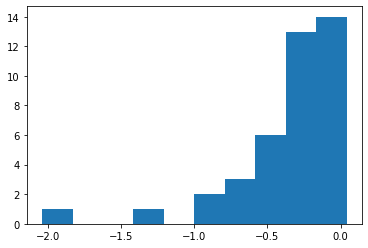

In [103]:
plt.hist(biggest.T[8])